In [17]:
import numpy as np
from math import ceil, floor
from qiskit import *
from qiskit.extensions import UnitaryGate
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

In [40]:
def valid_parameters(n,m,p):
    """
    Parameters
    ----------
    n : int
        Number of qubits encoding the vector
    m : int
        Number of qubits on which the implementation is done
    p : int
        Number of steps for the algorithm

    Returns
    -------
    bool
    """
    if n < 1:
        print('Error: n must be greater than 0')
        return False
    elif m > n or m < 1:
        print('Error: m must be such that 0 < m <= n')
        return False
    elif p%2 != 0 and p != 1 or p > 2**(m-1):
        print('Error: p must be even (except 1) and such that 1 <= p <= 2^(m-1)')
        return False
    else:
        return True
    
# G1
def g1(n,m,p):
    """
    Parameters
    ----------
    n : int
        Number of qubits encoding the vector
    m : int
        Number of qubits on which the implementation is done
    p : int
        Number of steps for the algorithm

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    if valid_parameters(n,m,p):
        x = QuantumRegister(n, name= 'x')
        c = AncillaRegister(p-1, name= 'c')
        x_aux = AncillaRegister(2**(m-1), name= "x'")
        
        qc = QuantumCircuit(x, c, x_aux)
        # copies
        
        for i in range(m-2):
            #qc.barrier()
            for j in range(i+1):
                for k in range(2**j):
                    index = p-2**(i+1)+i-int(2**j-1/2)-k
                    if index >= 0:
                        if k == 0:
                            qc.cnot(x[n-m+2+i],c[index])
                        else:
                            qc.cnot(c[index+2**j],c[index])
        #qc.barrier()
        qc.x(x_aux[0])
        # cswap
        
        copyDone = min(p-1,2**(m-1)-m) # total number of copies to perform
        for i in range(m-1):
            X = 2**i-i-1 # number of copies already done
            qc.barrier()
            for j in range(2**i):
                if j == 0:
                    qc.cswap(x[n-m+1+i],x_aux[j],x_aux[j+2**i])
                elif X + j - 1 < copyDone:
                    qc.cswap(c[p-2-X-j+1],x_aux[j],x_aux[j+2**i])
                else:
                    qc.cswap(x[n-m+1+i],x_aux[j],x_aux[j+2**i])
        
        return qc
    

# G2
def g2(n,m,p):
    """
    Parameters
    ----------
    n : int
        Number of qubits encoding the vector
    m : int
        Number of qubits on which the implementation is done
    p : int
        Number of steps for the algorithm

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    if valid_parameters(n,m,p):
        x = QuantumRegister(n, name= 'x')
        c = AncillaRegister(p-1, name= 'c')
        x_aux = AncillaRegister(2**(m-1), name= "x'")
        
        qc = QuantumCircuit(x, c, x_aux)

        for i in range(ceil(np.log2(p))):
            qc.barrier()
            if i == 0:
                qc.cswap(x[n-m+1],x[n-m],c[0])
            
            else:
                # cnots
                
                d = m-2-i
                # number of trees = 2**i
                for j in range(d):
                    # number of subtrees per layer
                    for k in range(2**i):
                        for l in range(2**(d-j-1)):
                            qc.cnot(x_aux[2**i * (2**(j+1)-1) + l*2**(i+j+2) + k], x_aux[2**i * (2**(j+1)-1) + l*2**(i+j+2) + 2**(i+j+1) + k])
                      
                # cswaps
                
                for j in range(2**i):
                    if j == 0:
                        qc.cswap(x_aux[2**(m-1)-2**i], x[n-m], c[2**i-1])
                    else:
                        index = (j-1+2**i)%(p-1)
                        if index == 0:
                            qc.barrier()
                            qc.cswap(x_aux[2**(m-1)-2**i+j], x[n-m], c[j-1])
                        elif index == j-1+2**i:
                            qc.cswap(x_aux[2**(m-1)-2**i+j], c[index], c[j-1])
                        else:
                            qc.cswap(x_aux[2**(m-1)-2**i+j], c[index-1], c[j-1])
                    
                # undo the cnots
                
                for j in range(d):
                    # number of subtrees per layer
                    for k in range(2**i): 
                        for l in range(2**j):
                            qc.cnot(x_aux[2**i * (2**(d-j)-1) + (2**(j)-1-l)*2**(i+d-j+1) + 2**i -1-k], x_aux[2**i * (2**(d-j)-1) + (2**(j)-1-l)*2**(i+d-j+1) + 2**(i+d-j) + 2**i -1-k])
                         
        return qc

# G0
def g0(n,m,p,f):
    """
    Parameters
    ----------
    n : int
        Number of qubits encoding the vector
    m : int
        Number of qubits on which the implementation is done
    p : int
        Number of steps for the algorithm
    f : function
        Function on [0,1]

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    if valid_parameters(n,m,p):
        x = QuantumRegister(n, name= 'x')
        c = AncillaRegister(p-1, name= 'c')
        x_aux = AncillaRegister(2**(m-1), name= "x'")
        
        qc = QuantumCircuit(x, c, x_aux)

        for i in range(ceil(2**(m-1)/p)):
            for j in range(min(p,2**(m-1)-i*p)):
                
                x1 = bin(j+i*p)[2:].zfill(m)[::-1]
                x2 = bin(1+j+i*p)[2:].zfill(m)[::-1]
                dyadic1, dyadic2 = 0, 0
                for k in range(m):
                    dyadic1 += int(x1[m-k-1])/2**(k+1)
                    dyadic2 += int(x2[m-k-1])/2**(k+1)
                unitary = np.array([[np.exp(1j*f(dyadic1)),0], [0,np.exp(1j*f(dyadic2))]])
                gate = UnitaryGate(unitary, label='C'+str(j+i*p))

                if j == 0:
                    qc.append(gate.control(1), [x_aux[j+i*p], x[n-m]])
                else:
                    qc.append(gate.control(1), [x_aux[j+i*p], c[j-1]])
                '''
                unitary = l[j+i*p]
                gate = UnitaryGate(unitary, label='C'+str(j+i*p))
                if j == 0:
                    qc.append(gate.control(1), [x_aux[j+i*p], x[n-m]])
                else:
                    qc.append(gate.control(1), [x_aux[j+i*p], c[j-1]])
                '''
        return qc
    
def circ(n,m,p,f):
    """
    Parameters
    ----------
    n : int
        Number of qubits encoding the vector
    m : int
        Number of qubits on which the implementation is done
    p : int
        Number of steps for the algorithm
    f : function
        Function on [0,1]

    Returns
    -------
    qiskit.circuit.quantumcircuit.QuantumCircuit
    """
    if valid_parameters(n,m,p):
        x = QuantumRegister(n, name= 'x')
        c = AncillaRegister(p-1, name= 'c')
        x_aux = AncillaRegister(2**(m-1), name= "x'")
        
        qc = QuantumCircuit(x, c, x_aux)
        all_qubits = [i for i in x] + [i for i in c] + [i for i in x_aux]
        
        g1_qc = g1(n,m,p)
        g2_qc = g2(n,m,p)
        g0_qc = g0(n,m,p,f)
        
        qc = qc.compose(g1_qc,all_qubits)
        qc = qc.compose(g2_qc,all_qubits)
        qc = qc.compose(g0_qc,all_qubits)
        qc = qc.compose(g2_qc.inverse(),all_qubits)
        qc = qc.compose(g1_qc.inverse(),all_qubits)
        
        return qc
    
    
# nouveau
def reordering2(l,n,m):
    # m = 1,...,n
    reordered_list = []
    
    for a in range(2):
        for i in range(2**(m-1)):
            for j in range(2**(n-m)):
                if a == 0:
                    reordered_list.append(l[j+i*2**(n-m+1)])
                else:
                    reordered_list.append(l[2**n-1-(j+i*2**(n-m+1))])
                    
    return reordered_list

# ancien
def reordering(l,n,p):
    # p = 0,...,n-1
    reordered_list = []
    r = 2**(n-p)
    for i in range(r):
        for j in range(2**p):
            reordered_list.append(l[i+j*r])
    return reordered_list

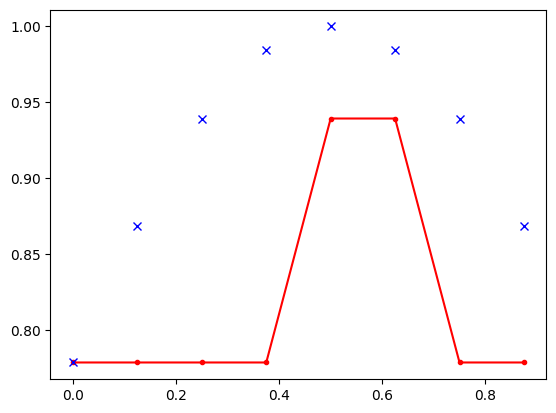

In [53]:
n = 3
m = 2
p = 1
    
def f(x):
    return np.exp(-(x-1/2)**2)

def f2(x):
    return np.sin(2*np.pi*x)

x = QuantumRegister(n, name= 'x')
c = AncillaRegister(p-1, name= 'c')
x_aux = AncillaRegister(2**(m-1), name= "x'")
qc = QuantumCircuit(x, c, x_aux)
    
qc.h(x)

all_qubits = [i for i in x] + [i for i in c] + [i for i in x_aux]
qc = qc.compose(circ(n,m,p,f),all_qubits)

state = qi.Statevector.from_instruction(qc)

L = np.array(state.data[0:2**n])
L2 = np.angle(L)
newL2 = reordering2(L2,n,m)
X = np.array(range(2**n))/2**n

plt.plot(X,newL2,marker='.',c='r')
plt.plot(X,f(X),marker='x',c='b',linestyle='')
plt.show()
#qc.draw()

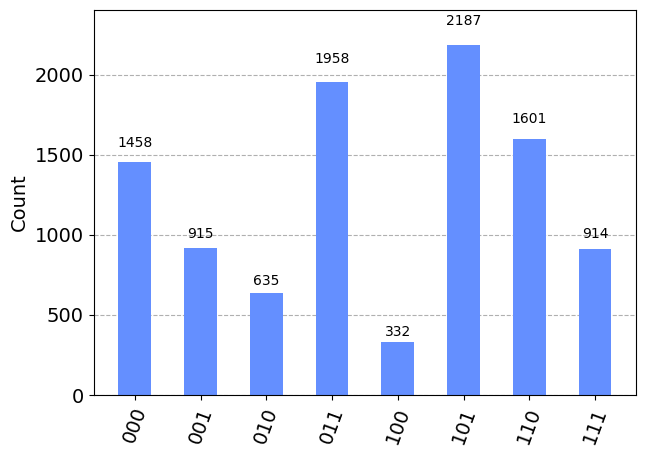

In [25]:
from qiskit.quantum_info import random_unitary

n = 3
m = 3
p = 1

l = [random_unitary(2).data for i in range(2**(m-1))]

x = QuantumRegister(n, name= 'x')
c = AncillaRegister(p-1, name= 'c')
x_aux = AncillaRegister(2**(m-1), name= "x'")
res = ClassicalRegister(n)
qc = QuantumCircuit(x, c, x_aux,res)
    
for i in range(n):
    if i != n-m:
        qc.h(x[i])

all_qubits = [i for i in x] + [i for i in c] + [i for i in x_aux]
qc = qc.compose(circ(n,m,p,f2,l),all_qubits)

qc.measure(x,res)

# execution

simulator = QasmSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=10000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

#qc.draw('mpl')